# Make Potential Publication Plots for WDS-Gaia Paper

In [15]:
from astropy.table import Table, vstack
from astropy.io import ascii
from astropy.coordinates import SkyCoord, Angle, Distance
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean, median, std, log, exp
%matplotlib inline
plt.style.use('seaborn-deep')

## Access the default color cycle from the style sheet

In [298]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
wds_color = default_colors[0] 
all_color = default_colors[5]
as_color = default_colors[2]
non_color = default_colors[1]

## Read in the wds table, query results table and the sorted results (so we can look at all the objects together as well as the sorted systems)

In [3]:
directory = '/home/sc36/dzakarian_wsl/wds_gaia_project/WDS_Gaia/'
wds_tab = Table.read(f'{directory}wdstab6-27.ecsv', header_start=0, data_start=1) 

query_results_tab = Table.read(f'{directory}/stack_query_results_table_fixed4-20.ecsv', header_start=0, data_start=1) 
index_error_queries = Table.read(f'{directory}/stack_index_error_queries_fixed4-20.ecsv', header_start=0, data_start=1) 

associated_systems_tab = Table.read(f'{directory}/associated_systems_table_fixed4-20.ecsv', header_start=0, data_start=1) 
non_associated_systems_tab = Table.read(f'{directory}/non_associated_systems_table_fixed4-20.ecsv', header_start=0, data_start=1) 

## if the first row is empty, delete the row... 
if associated_systems_tab[0]['ra_a'] == 0.0:
    associated_systems_tab.remove_row(0)



#### view columns for each table

In [5]:
wds_tab.info

<Table length=154513>
     name       dtype    unit      class     n_bad
-------------- ------- -------- ------------ -----
WDS Identifier   str13                Column     0
       Epoch-1   int64       yr       Column     0
       Epoch-2   int64       yr       Column     0
       Theta-1   int64      deg       Column     0
       Theta-2   int64      deg       Column     0
         Rho-1 float64   arcsec       Column     0
         Rho-2 float64   arcsec       Column     0
       Mag-pri    str5      mag       Column     0
       Mag-sec    str4      mag       Column     0
      PMpri-RA float64 mas / yr MaskedColumn  1959
     PMpri-DEC float64 mas / yr MaskedColumn  1958
      PMsec-RA float64 mas / yr MaskedColumn 47601
     PMsec-DEC float64 mas / yr MaskedColumn 47600
       WDS_RA"    str9                Column     0
      WDS_DEC"    str9                Column     0
      RAprideg float64      deg       Column     0
     DECprideg float64      deg       Column     0
         

In [6]:
query_results_tab.info

<Table length=93390>
             name               dtype    unit   n_bad
------------------------------ ------- -------- -----
                wds_identifier   str13              0
                    wds_rownum   int64              0
                   source_id_a   str19              0
                   source_id_b   str19              0
                   ref_epoch_a float64              0
                   ref_epoch_b float64              0
                          ra_a float64      deg     0
                          ra_b float64      deg     0
                    ra_error_a float64      mas     0
                    ra_error_b float64      mas     0
                         dec_a float64      deg     0
                         dec_b float64      deg     0
                   dec_error_a float64      mas     0
                   dec_error_b float64      mas     0
                    parallax_a float64      mas     0
                    parallax_b float64      mas     0
       

In [7]:
associated_systems_tab.info

<Table length=31407>
             name               dtype     unit    n_bad
------------------------------ ------- ---------- -----
                wds_identifier   str13                0
                    wds_rownum   int64                0
                   source_id_a   str19                0
                   source_id_b   str19                0
                   ref_epoch_a float64                0
                   ref_epoch_b float64                0
                          ra_a float64        deg     0
                          ra_b float64        deg     0
                    ra_error_a float64        mas     0
                    ra_error_b float64        mas     0
                         dec_a float64        deg     0
                         dec_b float64        deg     0
                   dec_error_a float64        mas     0
                   dec_error_b float64        mas     0
                    parallax_a float64        mas     0
                    paralla

## Plot 1) Projection of the WDS Sources on the Sky 

i) RA + Dec

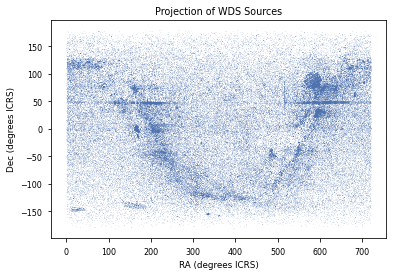

In [302]:
title='Projection of WDS Sources'
save_title=title.replace(' ', '_')
ras = wds_tab['RApri-prepped'] + wds_tab['RAsec-prepped']
decs = wds_tab['DECpri-prepped'] + wds_tab['DECsec-prepped']
plt.figure(figsize=(6, 4))
plt.scatter(ras, decs, color= wds_color, marker='o', alpha=0.2, s=.3)
plt.xlabel("RA (degrees ICRS)")
plt.ylabel("Dec (degrees ICRS)")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

ii) Galactic Coordinates

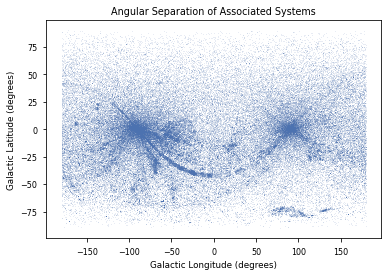

In [317]:
# Define the Galactic coordinate transformation function
def equatorial_to_galactic(ra, dec):
    # Convert RA and Dec to radians
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    # Define the Galactic center in equatorial coordinates
    l0 = np.radians(0)  # Galactic center longitude in radians
    b0 = np.radians(0)  # Galactic center latitude in radians

    # Calculate Galactic longitude (l) and latitude (b)
    l = np.arctan2(np.sin(ra_rad - l0), np.cos(dec_rad) * np.tan(b0) - np.sin(dec_rad) * np.cos(ra_rad - l0))
    b = np.arcsin(np.sin(dec_rad) * np.sin(b0) + np.cos(dec_rad) * np.cos(b0) * np.cos(ra_rad - l0))

    # Convert l and b back to degrees
    l_deg = np.degrees(l)
    b_deg = np.degrees(b)

    return l_deg, b_deg

# Assuming you have a table of equatorial coordinates in 'ras' and 'decs'
# Convert equatorial coordinates to Galactic coordinates
galactic_coords = [equatorial_to_galactic(ra, dec) for ra, dec in zip(ras, decs)]
l_values, b_values = zip(*galactic_coords)

# Create the plot in Galactic coordinates
plt.figure(figsize=(6, 4))
plt.scatter(l_values, b_values, color=wds_color, marker='o', alpha=0.2, s=0.3)
plt.xlabel("Galactic Longitude (degrees)")
plt.ylabel("Galactic Latitude (degrees)")
plt.title(title)
plt.savefig(f'{save_title}_galactic.png', dpi=300, bbox_inches='tight')

## Plot 2) Projection of the WDS-Gaia Sources on the Sky

a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

#### A) all query results

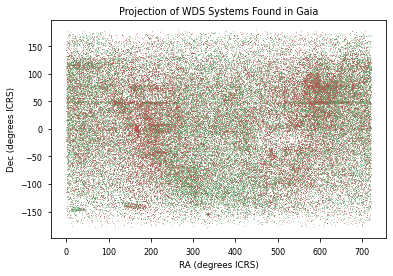

In [318]:
as_ras = associated_systems_tab['ra_a'] + associated_systems_tab['ra_b']
as_decs = associated_systems_tab['dec_a'] + associated_systems_tab['dec_b']
non_ras = non_associated_systems_tab['ra_a'] + non_associated_systems_tab['ra_b']
non_decs = non_associated_systems_tab['dec_a'] + non_associated_systems_tab['dec_b']

title = 'Projection of WDS Systems Found in Gaia'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_ras, non_decs, color=non_color, marker='o', alpha=0.8, s=.3)
plt.scatter(as_ras, as_decs, color = as_color, marker='o', alpha=0.8, s=.3) 

plt.xlabel("RA (degrees ICRS)")
plt.ylabel("Dec (degrees ICRS)")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')



#### B) Associated Pairs

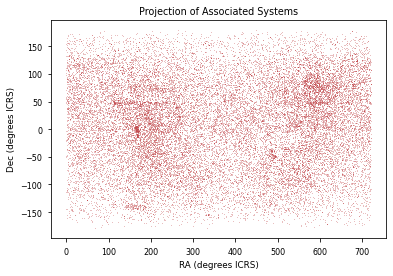

In [319]:
as_ras = associated_systems_tab['ra_a'] + associated_systems_tab['ra_b']
as_decs = associated_systems_tab['dec_a'] + associated_systems_tab['dec_b']

title = 'Projection of Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(as_ras, as_decs, color=as_color, marker='o', alpha=0.6, s=.3) 

plt.xlabel("RA (degrees ICRS)")
plt.ylabel("Dec (degrees ICRS)")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

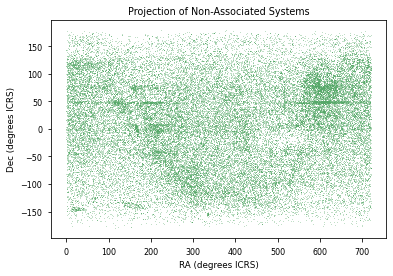

In [320]:
non_ras = non_associated_systems_tab['ra_a'] + non_associated_systems_tab['ra_b']
non_decs = non_associated_systems_tab['dec_a'] + non_associated_systems_tab['dec_b']

title = 'Projection of Non-Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_ras, non_decs, color=non_color, marker='o', alpha=0.6, s=.3)

plt.xlabel("RA (degrees ICRS)")
plt.ylabel("Dec (degrees ICRS)")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')


## Plot 3) Angular Separation Histogram
a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

#### A) WDS 

In [305]:
ra_as = wds_tab['RApri-prepped'] 
ra_bs = wds_tab['RAsec-prepped']
dec_as = wds_tab['DECpri-prepped'] 
dec_bs = wds_tab['DECsec-prepped']

acoords = SkyCoord(ra_as, dec_as, frame='icrs')
bcoords = SkyCoord(ra_bs, dec_bs, frame='icrs')


# calcualte the separation between the two objects
wds_seps = acoords.separation(bcoords).to(u.arcsec).value


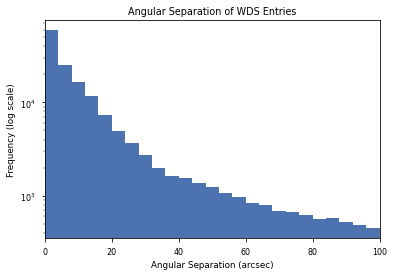

In [306]:
title = 'Angular Separation of WDS Entries'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
plt.hist(wds_seps, bins=25, range=(0, 100), color=wds_color, log=True)
plt.title(title)
plt.xlabel('Angular Separation (arcsec)')
plt.ylabel('Frequency (log scale)')
plt.xlim(0, 100)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### B) All Query Results

In [313]:
all_seps = np.concatenate((associated_systems_tab['separation'], non_associated_systems_tab['separation']))

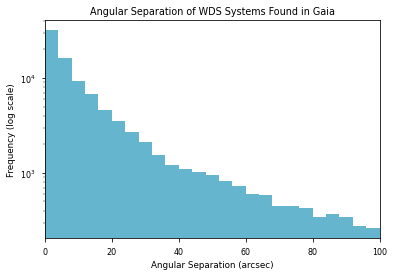

In [314]:
title = 'Angular Separation of WDS Systems Found in Gaia'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
plt.hist(all_seps, bins=25, range=(0, 100), color=all_color, log=True)
plt.title(title)
plt.xlabel('Angular Separation (arcsec)')
plt.ylabel('Frequency (log scale)')
plt.xlim(0, 100)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### C) Associated Systems

In [315]:
as_seps = associated_systems_tab['separation']

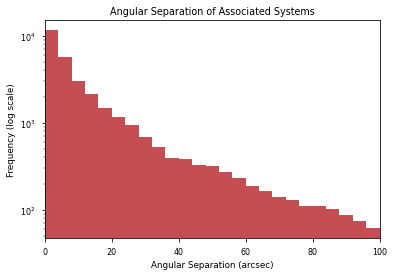

In [316]:
title = 'Angular Separation of Associated Systems'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
plt.hist(as_seps, bins=25, range=(0, 100), color=as_color, log=True)
plt.title(title)
plt.xlabel('Angular Separation (arcsec)')
plt.ylabel('Frequency (log scale)')
plt.xlim(0, 100)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### D) Non-Associated Systems

In [28]:
non_seps = non_associated_systems_tab['separation']

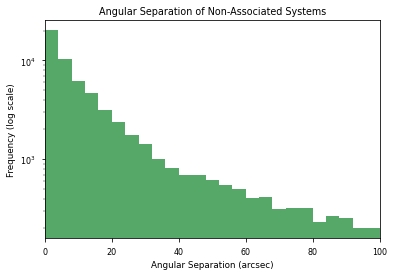

In [29]:
title = 'Angular Separation of Non-Associated Systems'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
plt.hist(non_seps, bins=25, range=(0, 100), color=non_color, log=True)
plt.title(title)
plt.xlabel('Angular Separation (arcsec)')
plt.ylabel('Frequency (log scale)')
plt.xlim(0, 100)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

## <span style="color:hotpink">**Plot 4) Physical Separation Histogram**</span>

a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

#### i) Calculate 3d separation between each pair

In [383]:
as_ra_a = associated_systems_tab['ra_a']
as_ra_b = associated_systems_tab['ra_b']
as_dec_a = associated_systems_tab['dec_a'] 
as_dec_b = associated_systems_tab['dec_b']

non_ra_a = non_associated_systems_tab['ra_a'] 
non_ra_b = non_associated_systems_tab['ra_b']
non_dec_a = non_associated_systems_tab['dec_a'] 
non_dec_b = non_associated_systems_tab['dec_b']

# the original measurements are in mas, but I want to read in the parallax in arcsec
# I checked - this correctly reads in parallax in arcsec
as_parallax_a = associated_systems_tab['parallax_a'].to(u.arcsec)
as_parallax_b = associated_systems_tab['parallax_b'].to(u.arcsec)
non_parallax_a = non_associated_systems_tab['parallax_a'].to(u.arcsec)
non_parallax_b = non_associated_systems_tab['parallax_b'].to(u.arcsec)

# calculate the distances in pc as 1/parallax[arcsec]
as_dist_a = 1 / as_parallax_a
as_dist_b = 1 / as_parallax_b
non_dist_a = 1 / non_parallax_a
non_dist_b = 1 / non_parallax_b

# distance is now in units of pc but astropy doesn't recognize this conversion from 1/arcsec (because it's not universal)
# so, fix the units manually
as_dist_a = as_dist_a*u.arcsec*u.pc
as_dist_b = as_dist_b*u.arcsec*u.pc
non_dist_a = non_dist_a*u.arcsec*u.pc
non_dist_b = non_dist_b*u.arcsec*u.pc

In [202]:
as_nom_dists

<Quantity [135.92673548, 626.65002165, 103.70943834, ..., 167.10885347,
           428.90582215, 145.04608604] pc>

In [195]:
# the tables have the 2d separations
as_seps = associated_systems_tab['separation']
non_seps = non_associated_systems_tab['separation']
all_seps = np.concatenate((associated_systems_tab['separation'], non_associated_systems_tab['separation']))

# pi is the symbol for parallax
# each pair will be set to the distance of the brighter object
# these lists will store the correct parallax depending on the mags of each pair
as_pis = []
non_pis = []

# find brighter component and its parallax for associated systems
for row in range(len(associated_systems_tab)):
    mag_a = associated_systems_tab['phot_g_mean_mag_a'][row]
    mag_b = associated_systems_tab['phot_g_mean_mag_b'][row]
    if mag_a < mag_b:
        as_pis.append(associated_systems_tab[row]['parallax_a'])
        
    else:
        as_pis.append(associated_systems_tab[row]['parallax_b'])

# find brighter component and its parallax for non-associated systems
for row in range(len(non_seps)):
    mag_a = non_associated_systems_tab['phot_g_mean_mag_a'][row]
    mag_b = non_associated_systems_tab['phot_g_mean_mag_b'][row]
    if mag_a < mag_b:
        non_pis.append(non_associated_systems_tab[row]['parallax_a'])
        
    else:
        non_pis.append(non_associated_systems_tab[row]['parallax_b'])

# convert parallax from arcsec to mas
as_pis = np.array(as_pis)
as_pis = as_pis*u.mas
as_pis = as_pis.to(u.arcsec)

# parallaxes -> distances
# the nominal distances are simply the brighter object distance
# used to calculate the projected physical separation
as_nom_dists = 1/ as_pis
as_nom_dists = as_nom_dists*u.pc*u.arcsec

In [196]:
as_nom_dists

<Quantity [135.92673548, 626.65002165, 103.70943834, ..., 167.10885347,
           428.90582215, 145.04608604] pc>

In [213]:
# make skycoord objects of the objects at their phsysical distances

as_obj_a = SkyCoord(ra=as_ra_a, dec=as_dec_a, distance=as_dist_a )
as_obj_b = SkyCoord(ra=as_ra_b, dec=as_dec_b, distance=as_dist_b )

non_obj_a = SkyCoord(ra=non_ra_a, dec=non_dec_a, distance=non_dist_a )
non_obj_b = SkyCoord(ra=non_ra_b, dec=non_dec_b, distance=non_dist_b )

# physical separations are calculated using astropy
as_phys_seps = np.concatenate([as_obj_a.separation_3d(as_obj_b).value])
non_phys_seps = np.concatenate([non_obj_a.separation_3d(non_obj_b).value])
all_phys_seps = np.concatenate([as_phys_seps, non_phys_seps])

# nominal separations calculated by putting both objects at the same (nominal) distance for the system
as_nom_obj_a = SkyCoord(ra=as_ra_a, dec=as_dec_a, distance=as_nom_dists )
as_nom_obj_b = SkyCoord(ra=as_ra_b, dec=as_dec_b, distance=as_nom_dists )

as_nominal_seps = np.concatenate([as_nom_obj_a.separation_3d(as_nom_obj_b).value])

In [391]:
median(as_phys_seps)

1.882715890919092

In [237]:
as_row = associated_systems_tab[1]['parallax_error_b']*u.mas
# as_row.to(u.arcsec)
as_row

<Quantity 0.04530474 mas>

#### A) All Query Results

i) physical sep

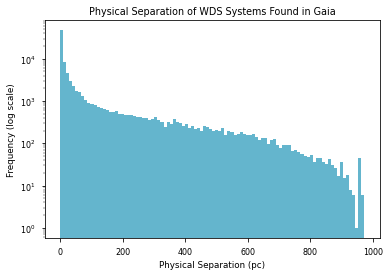

In [206]:
title = 'Physical Separation of WDS Systems Found in Gaia'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
# plt.hist(all_phys_seps, bins=25, range=(0, 100), color=all_color, log=True)
plt.hist(all_phys_seps, bins=100, color=all_color, log=True)
plt.title(title)
plt.xlabel('Physical Separation (pc)')
plt.ylabel('Frequency (log scale)')
# plt.xlim(0, 1000)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### B) Associated Systems

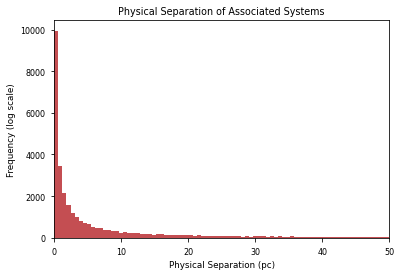

In [400]:
# Switching to log=True shows the larger separations

title = 'Physical Separation of Associated Systems'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
# plt.hist(all_phys_seps, bins=25, range=(0, 100), color=all_color, log=True)
plt.hist(as_phys_seps, bins=1000, color=as_color, log=False)
plt.title(title)
plt.xlim(0,50)
plt.xlabel('Physical Separation (pc)')
plt.ylabel('Frequency (log scale)')
# plt.xlim(0, 1000)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

In [412]:
small_seps=[]

for obj in range(len(as_phys_seps)):
    if as_phys_seps[obj] <5:
        small_seps.append(as_phys_seps[obj])

In [413]:
len(small_seps)/len(as_phys_seps)

0.6655204253828765

31407

In [408]:
20902/31407

0.6655204253828765

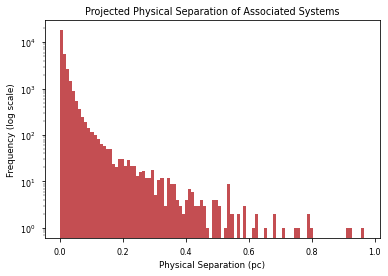

In [394]:
title = 'Projected Physical Separation of Associated Systems'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
# plt.hist(all_phys_seps, bins=25, range=(0, 100), color=all_color, log=True)
plt.hist(as_nominal_seps, bins=100, color=as_color, log=True)
plt.title(title)
plt.xlabel('Physical Separation (pc)')
plt.ylabel('Frequency (log scale)')
# plt.xlim(0, 1000)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### C) Non-Associated Systems

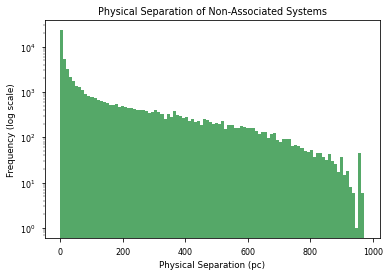

In [127]:
title = 'Physical Separation of Non-Associated Systems'
save_title = title.replace(' ', '_')


plt.figure(figsize=(6, 4))
# plt.hist(all_phys_seps, bins=25, range=(0, 100), color=all_color, log=True)
plt.hist(non_phys_seps, bins=100, color=non_color, log=True)
plt.title(title)
plt.xlabel('Physical Separation (pc)')
plt.ylabel('Frequency (log scale)')
# plt.xlim(0, 1000)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

### Plot 5) Delta-Mag Histogram

a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

In [215]:
len(query_results_tab)

93402

## Plot 6) Mag vs Mag plot

a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

In [232]:
as_mag_a = associated_systems_tab['phot_g_mean_mag_a']
as_mag_b = associated_systems_tab['phot_g_mean_mag_b']
non_mag_a = non_associated_systems_tab['phot_g_mean_mag_a']
non_mag_b = non_associated_systems_tab['phot_g_mean_mag_b']

#### A) All Systems

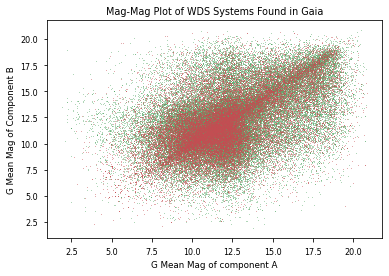

In [356]:
title = 'Mag-Mag Plot of WDS Systems Found in Gaia'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_mag_a, non_mag_b, color=non_color, marker='o', alpha=0.8, s=.3)
plt.scatter(as_mag_a, as_mag_b, color = as_color, marker='o', alpha=0.8, s=.3) 

plt.xlabel("G Mean Mag of component A")
plt.ylabel("G Mean Mag of Component B")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')



#### Associated Systems

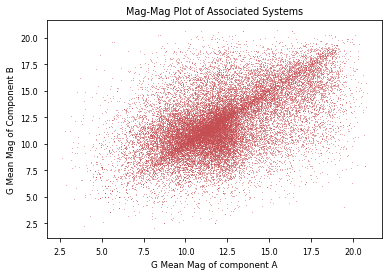

In [358]:
title = 'Mag-Mag Plot of Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(as_mag_a, as_mag_b, color = as_color, marker='o', alpha=0.8, s=.3) 

plt.xlabel("G Mean Mag of component A")
plt.ylabel("G Mean Mag of Component B")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

#### Non-Associated Systems

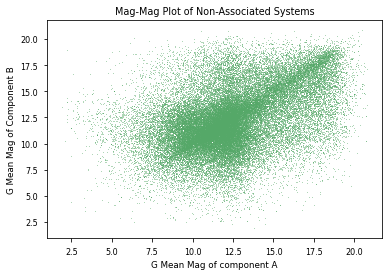

In [359]:
title = 'Mag-Mag Plot of Non-Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_mag_a, non_mag_b, color=non_color, marker='o', alpha=0.8, s=.3)

plt.xlabel("G Mean Mag of component A")
plt.ylabel("G Mean Mag of Component B")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')

### Plot 7) Color Magnitude Diagram

a] Both together (distinguished by color)

b] Just the physical pairs

c] Just the non-physical pairs

In [360]:
as_mag_a = associated_systems_tab['phot_g_mean_mag_a']
as_mag_b = associated_systems_tab['phot_g_mean_mag_b']
non_mag_a = non_associated_systems_tab['phot_g_mean_mag_a']
non_mag_b = non_associated_systems_tab['phot_g_mean_mag_b']

as_bprp_a = associated_systems_tab['bp_rp_a']
as_bprp_b = associated_systems_tab['bp_rp_b']
non_bprp_a = non_associated_systems_tab['bp_rp_a']
non_bprp_b = non_associated_systems_tab['bp_rp_b']

#### A) All Systems

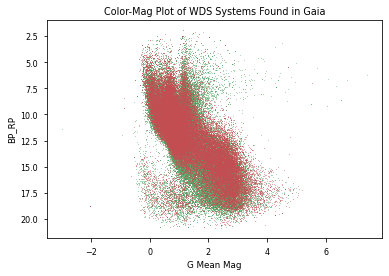

In [374]:
title = 'Color-Mag Plot of WDS Systems Found in Gaia'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_bprp_a, non_mag_a, color=non_color, marker='o', alpha=0.8, s=.3)
plt.scatter(non_bprp_b, non_mag_b, color=non_color, marker='o', alpha=0.8, s=.3)
plt.scatter(as_bprp_a, as_mag_a, color = as_color, marker='o', alpha=0.8, s=.3) 
plt.scatter(as_bprp_b, as_mag_b, color = as_color, marker='o', alpha=0.8, s=.3) 

plt.gca().invert_yaxis()

plt.xlabel("G Mean Mag")
plt.ylabel("BP_RP")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')


#### B) Associated Systems

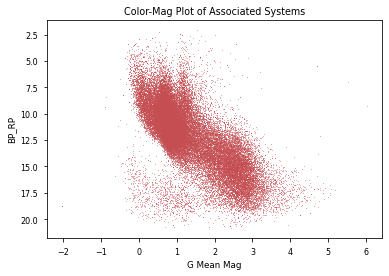

In [372]:
title = 'Color-Mag Plot of Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))

plt.scatter(as_bprp_a, as_mag_a, color = as_color, marker='o', alpha=0.8, s=.3) 
plt.scatter(as_bprp_b, as_mag_b, color = as_color, marker='o', alpha=0.8, s=.3) 

plt.gca().invert_yaxis()

plt.xlabel("G Mean Mag")
plt.ylabel("BP_RP")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')


#### Non-Associated Systems

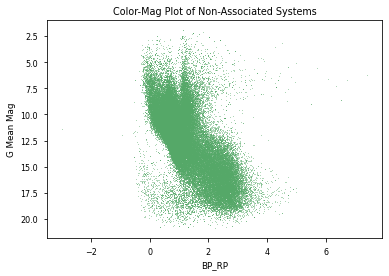

In [373]:
title = 'Color-Mag Plot of Non-Associated Systems'
save_title=title.replace(' ', '_')

plt.figure(figsize=(6, 4))
plt.scatter(non_bprp_a, non_mag_a, color=non_color, marker='o', alpha=0.8, s=.3)
plt.scatter(non_bprp_b, non_mag_b, color=non_color, marker='o', alpha=0.8, s=.3)

plt.gca().invert_yaxis()

plt.ylabel("G Mean Mag")
plt.xlabel("BP_RP")
plt.title(title)
plt.savefig(f'{save_title}.png', dpi=300, bbox_inches='tight')
